In [1]:
import numpy as np
import scipy.sparse as sparse
from sklearn import neighbors, svm, naive_bayes
import matplotlib.pyplot as pl
import random

%matplotlib inline

In [2]:
metadata_path = '~/audiosearch/data/UrbanSound8K/metadata/UrbanSound8K_by_fold.csv'
fold_path = '/home/mzhan/audiosearch/data/UrbanSound8K/folds.csv'
class_path = '/home/mzhan/audiosearch/data/UrbanSound8K/classes.csv'
feature_path = '/home/mzhan/audiosearch/data/UrbanSound8K/features2.npy'
centroid_path = '/home/mzhan/audiosearch/data/UrbanSound8K/centroids151209.npy'


### Load original data

In [3]:
def showX(X):
    """ X: training data of shape (n,d) """
    n,d = X.shape
    width = n/500+2
    pl.figure(figsize=(width,8))
    pl.imshow(X.T, aspect='auto', interpolation='none', cmap = pl.cm.OrRd, extent=[0,n,0,d])
    pl.xticks([n],[n])
    #pl.ylim([256, 511])
    pl.colorbar()


In [4]:
def showP(p):
    """ p: predicted probility of shape (n, n_class) """
    n,c = p.shape
    width = n/100+2
    pl.figure(figsize=(width,c))
    pl.imshow(p.T, aspect='auto', interpolation='none', cmap = pl.cm.OrRd, extent=[0,n,0,c])
    pl.xticks([n],[n])
    if c==2:
        # binary case
        pl.yticks([0.5, 1.5], [False, True])
    else:
        pl.yticks(np.arange(c)+0.5, np.arange(c))
    #pl.ylim([256, 511])
    pl.colorbar()


<matplotlib.colorbar.Colorbar instance at 0x7f1f8cc725a8>

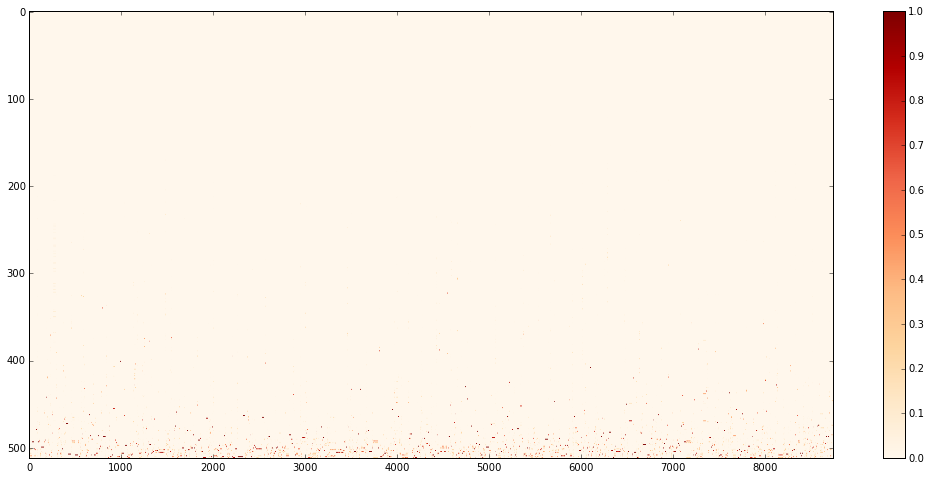

In [6]:
# Load and display data
Xraw = np.load(feature_path)
Yraw = np.loadtxt(class_path)
sums = Xraw.sum(1).reshape((len(Xraw),1))
normalized = np.divide(Xraw, sums, dtype=float)

# sort features
sort_inds = normalized.sum(0).argsort()
Xsorted = normalized[:,sort_inds]

pl.figure(figsize=(18,8))
pl.imshow(Xsorted.T, aspect='auto', cmap = pl.get_cmap('OrRd'))
#pl.ylim([256, 511])
pl.colorbar()


#### Many features don't matter much... Further dimension reduction

In [11]:
cut = 200
Xcut = Xsorted[:, :cut]
print np.max(Xcut), np.median(Xcut), np.mean(Xcut)
print np.sum(Xcut>0.01), 'files contain features of frequciecies greater than 0.1'


# data after dimension reduction
X = Xsorted[:,cut:]

0.118925831202 0.0 3.84449241717e-06
157 files contain features of frequciecies greater than 0.1


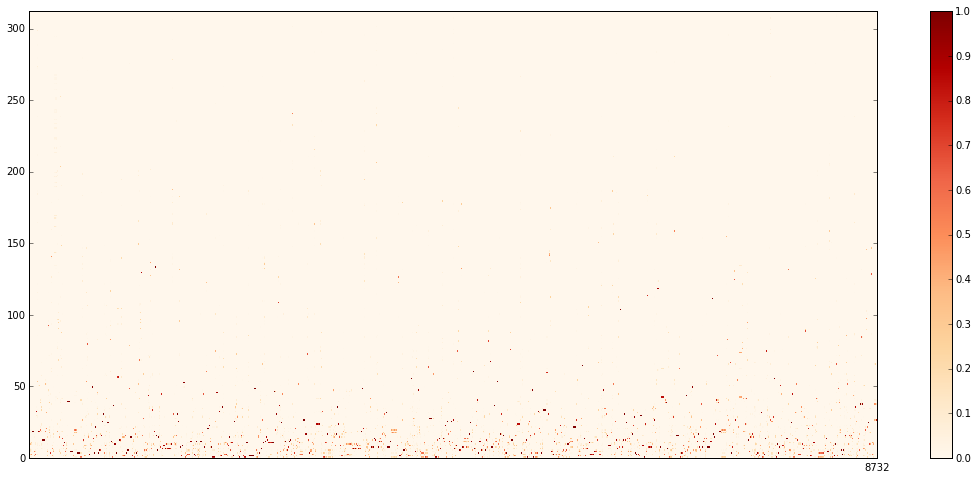

In [12]:
showX(X)

## Adapt data for the case of audio query, i.e. binary classification. 

In [10]:
# Suppose we want to find dog barks (classID=3)
target_class = 3 
Y = (Yraw==target_class)

In [13]:
# Standard ML setup
random.seed(12345)
fold_partition = range(10)
random.shuffle(fold_partition)
folds = np.loadtxt(fold_path)

def train(c, train_inds, verbose=False):
    c.fit(X[train_inds], Y[train_inds])
    if verbose:
        ntrain = train_inds.sum()
        correct = (c.predict(X[train_inds])==Y[train_inds])
        print correct.sum()*1./ntrain
   
def validate(c, validate_inds):
    nval = validate_inds.sum()
    vcorrect = (c.predict(X[validate_inds])==Y[validate_inds])
    return vcorrect.sum()*1./nval

def crossvalidate(c):
    print c
    cv = []
    for f in fold_partition[:6]:
        validate_inds = (folds == f)
        nval = validate_inds.sum()
        train_inds = np.any([folds == ft for ft in fold_partition[:6] if ft!=f ], axis=0)
        ntrain = train_inds.sum()

        train(c, train_inds)
        cv.append(validate(c, validate_inds))
    return cv

In [14]:
c = neighbors.KNeighborsClassifier()
crossvalidate(c)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')


[0.82703321878579605,
 0.85081081081081078,
 0.81495098039215685,
 0.84081196581196582,
 0.77295285359801491,
 0.87708830548926009]

In [15]:
c = naive_bayes.GaussianNB()
crossvalidate(c)

GaussianNB()


[0.88201603665521189,
 0.82486486486486488,
 0.78308823529411764,
 0.67094017094017089,
 0.76799007444168732,
 0.62410501193317425]

In [16]:
c = svm.LinearSVC()
crossvalidate(c)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


[0.86827033218785798,
 0.88108108108108107,
 0.86887254901960786,
 0.83653846153846156,
 0.85235732009925558,
 0.883054892601432]

All seem to do well for the binary case, which is promising... Next we'll try interactive learning!



##  1. Interact through example

#### 1.0. Set search scope

In [57]:
# Take a fold as search scope
scope_fold = 5
fold = np.loadtxt(fold_path)
scope = (fold==scope_fold)

Xs, Ys = (X[scope], Y[scope])

# The rest serves as source of query examples
not_scope = np.logical_not(scope)
Xn, Yn = (X[not_scope], Y[not_scope])
#print "in scope:", Xs.shape, Ys.shape
#print "out of scope:", Xn.shape, Yn.shape
print 'scope size', scope.sum()
#showX(Xs)
#showX(Xn)

scope size 936


#### 1.1 Initial query examples

In [58]:
#random.seed(12345)
n_examples = 3   # number of examples

# Select examples from outside the search scope
t_inds = range(Yn.sum())  
random.shuffle(t_inds)
selected = t_inds[:n_examples]   
examples = Xn[Yn][selected]   

print Yn[Yn][selected]
#showX(examples)

[ True  True  True]


#### 1.2 Classifier proposes initial suggestions. 

Since no negative is given, simply rank unknown data by distance to query examples. 
Also start maintaining proposed samples. 

In [59]:
n_propose = 10
m = neighbors.DistanceMetric.get_metric('minkowski')
dists = m.pairwise(Xs, examples)
mean_dists = dists.mean(axis=1)

# proposal sample index as within the search scope 
scope_sorted = np.argsort(mean_dists)
scope_proposed = scope_sorted[:n_propose] 

[3971 3973 4038 3974 3970 3972 3976 3969 4039 3951]
[False False  True False False False False False  True False]
scope size new: 926


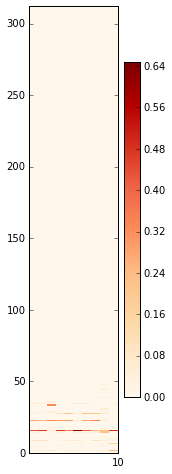

In [60]:
# proposal sample index as in complete data
proposed = np.arange(len(X))[scope][scope_proposed]

print proposed 
print Y[proposed]
showX(X[proposed])

# maintain feedback examples
feedback = proposed

# Update scope to exclude feedback
scope[proposed]=False
print 'scope size new:', scope.sum()

#### 1.3 User responds to proposals. 

Now we probably have negative examples and do some real training.
Classifier updates itself and propose new results.

In [61]:
# Need to take care of balancing samples
c1 = neighbors.KNeighborsClassifier()

[4058 4078 4077 4076 4075 4074 4073 4072 4071 4070]
[False False False False False False False False False False]
[3971 3973 4038 3974 3970 3972 3976 3969 4039 3951 4037 3676 4230 4231 4232
 4233 4535 4235 4236 4534 4257 4213 4209 4208 4207 3726 4206 4204 4584 4311
 4058 4078 4077 4076 4075 4074 4073 4072 4071 4070]


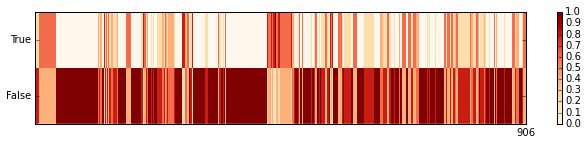

In [64]:
c1.fit(np.concatenate((examples,X[feedback]), axis=0), np.concatenate((np.ones((n_examples,)), Y[feedback])))
p = c1.predict_proba(X[scope])
showP(p)
scope_sorted = np.argsort(p[:,0])   
scope_proposed = scope_sorted[:n_propose]
proposed = np.arange(len(X))[scope][scope_proposed]


print proposed 
# new feedback
print Y[proposed]
# update feedback data
scope[proposed]=False
feedback = np.concatenate((feedback, proposed))
print feedback